## Deep Double Descent

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle
import json
import yaml
import os
from collections import OrderedDict

import torch
from torch import nn
from torch.utils import data

import torchvision
from torchvision import transforms

from IPython import display

print(f'GPU available: {torch.cuda.is_available()}')

GPU available: True


### Setup

In [2]:
def training_set_labelnoise(train_data, noise_ratio=0.2):
    
    # create deepcopy
    import copy
    noisy = copy.deepcopy(train_data)
    noisy.data = copy.deepcopy(train_data.data)
    noisy.targets = copy.deepcopy(train_data.targets)
    
    n_classes = len(noisy.classes)
    targets = noisy.targets
    targets_set = targets.unique()
    
    # generate mislabels for each cls
    for cls in range(n_classes):
        
        cls_mask = (targets == cls)
        targets_filtered = np.array(targets[cls_mask])
        
        wrong_target_cls = [x for x in targets_set if x != cls] # labels other than cls
        n_mislabels = int(len(targets_filtered)*noise_ratio) # number of mislabels for cls
        
        wrong_targets = np.random.choice(wrong_target_cls, size=n_mislabels)
        random_boolean = np.random.permutation([True]*n_mislabels + [False]*(len(targets_filtered) - n_mislabels))
        targets_filtered[random_boolean] = wrong_targets
        targets[cls_mask] = torch.tensor(targets_filtered)
        
    noisy.targets = targets
    
    return noisy

def load_data_fashion_mnist(batch_size, resize=None, num_workers=8):
    
    # Use [] iterable because we use transform.Compose and possibly insert below
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize)) # Add resizing as optional transformation
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root='../data', train=True, transform=trans, download=True, target_transform=None)
    mnist_test = torchvision.datasets.FashionMNIST(
        root='../data', train=False, transform=trans, download=True, target_transform=None)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=num_workers),
            data.DataLoader(mnist_test, batch_size, shuffle=True, num_workers=num_workers)
           )

def load_data_mnist(batch_size, train_size=None, test_size=None, label_noise=False, noise_ratio=0.2, resize=None, num_workers=8):
    
    # Use [] iterable because we use transform.Compose and possibly insert below
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize)) # Add resizing as optional transformation
    trans = transforms.Compose(trans)
    
    mnist_train = torchvision.datasets.MNIST(
        root='../data', train=True, transform=trans, download=True, target_transform=None)
    mnist_test = torchvision.datasets.MNIST(
        root='../data', train=False, transform=trans, download=True, target_transform=None)
    
    if label_noise:
        mnist_train = training_set_labelnoise(mnist_train, noise_ratio=noise_ratio)
    
    if train_size is not None:
        indices = np.random.choice(len(mnist_train), size=train_size, replace=False)
        mnist_train = data.Subset(mnist_train, indices)
        
    if test_size is not None:
        indices = np.random.choice(len(mnist_test), size=test_size, replace=False)
        mnist_test = data.Subset(mnist_test, indices)
    
    return (data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=num_workers),
            data.DataLoader(mnist_test, batch_size, shuffle=True, num_workers=num_workers)
           )

def try_gpu():
    if torch.cuda.is_available():
        return torch.device('cuda:0')
    else:
        return torch.device('cpu')

In [3]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend, title):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    axes.set_title(title)
    if legend:
        axes.legend(legend)
    axes.grid()

class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, title=None, xscale='linear', yscale='log',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        display.set_matplotlib_formats('svg')
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(self.axes[
            0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend, title)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

class Accumulator:
    def __init__(self, n):
        self.data = [0.0]*n
        
    def add(self, *args):
        self.data = [a + b for a, b in zip(self.data, args)]
        
    def __getitem__(self, idx):
        return self.data[idx]

def train(net, train_iter, test_iter, num_epochs, loss, optimizer, device):
    
    # initialize weights
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.kaiming_normal_(m.weight)
    net.apply(init_weights)
    
    # setup
    # optimizer = torch.optim.AdamW(net.parameters(), lr=lr)
    # loss = nn.CrossEntropyLoss()
    num_batches = len(train_iter)
    net.to(device)
    
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'test loss'], title=f'hidden layer: {net[1]}')
    
    train_loss_ls, test_loss_ls = [], []
    for epoch in range(num_epochs):
        
        # train loop
        net.train()
        metric_train = Accumulator(2)
        for batch, (X, y) in enumerate(train_iter, 1):
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            yhat = net(X)
            l = loss(yhat, y)
            l.backward()
            optimizer.step()
            
            with torch.no_grad():
                metric_train.add(l*y.numel(), y.numel())
            train_loss = metric_train[0]/metric_train[1]
            train_loss_ls.append(train_loss)
                
        # test loop
        net.eval()
        metric_test = Accumulator(2)
        for X, y in test_iter:
            with torch.no_grad():
                X, y = X.to(device), y.to(device)
                yhat = net(X)
                l = loss(yhat, y)
                metric_test.add(l*y.numel(), y.numel())
                
                test_loss = metric_test[0]/metric_test[1]
                test_loss_ls.append(test_loss)
                
        animator.add(epoch+1, (train_loss, test_loss))
    
    return animator, train_loss_ls, test_loss_ls

### Submit Parallel Jobs with run_model.py

In [192]:
d_hiddens = [60,70,80,90,100,150,200,250,300,350,400,450,500,600,700,800,900,1000]
d_hiddens, len(d_hiddens)

([60,
  70,
  80,
  90,
  100,
  150,
  200,
  250,
  300,
  350,
  400,
  450,
  500,
  600,
  700,
  800,
  900,
  1000],
 18)

In [193]:
# for d_hidden in d_hiddens:
#     ! sbatch run_model.sh {d_hidden}

Submitted batch job 6010568
Submitted batch job 6010569
Submitted batch job 6010570
Submitted batch job 6010571
Submitted batch job 6010572
Submitted batch job 6010573
Submitted batch job 6010574
Submitted batch job 6010575
Submitted batch job 6010576
Submitted batch job 6010577
Submitted batch job 6010578
Submitted batch job 6010579
Submitted batch job 6010580
Submitted batch job 6010581
Submitted batch job 6010582
Submitted batch job 6010583
Submitted batch job 6010584
Submitted batch job 6010585


### Results

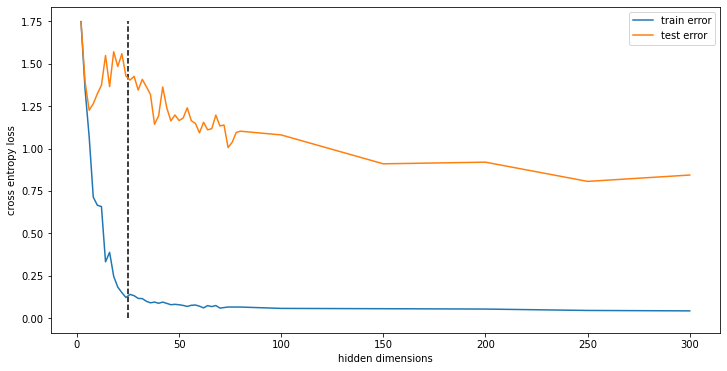

In [12]:
# Label noise is critical for double descent!
with open('./mnist_train2000_test10000_epoch500_labelnoise30/data.pkl', 'rb') as f:
    tmp = pickle.load(f)
    
tmp = dict(sorted(tmp.items()))
end_ind = 45

params = np.array(list(tmp.keys()))[:end_ind]
train_errs = np.array(list(tmp.values()))[:,0][:end_ind]
test_errs = np.array(list(tmp.values()))[:,1][:end_ind]

fig = plt.figure(figsize=(12,6))
plt.plot(params, train_errs, label='train error')
plt.plot(params, test_errs, label='test error')
plt.xlabel('hidden dimensions')
plt.ylabel('cross entropy loss')
plt.vlines(25, 0.0, 1.75, linestyles='--', color='k')
plt.legend()

In [13]:
fig.savefig('double_descent.png', bbox_inches='tight')